# Progress file for NER training

## [Installatie](#Installatie)

### Installeer spacy in jupyter notebook env

In [1]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install unicode

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### Installeer spacy voor windows

1. Installeer anaconda
    <div>Dit geeft een goede python omgeving om in te werken.</div>


2. Installeer spacy in de anaconda terminal
<div class="alert alert-block alert-info">conda install -c conda-forge spacy </div>

### Installeer spacy for linux

In een terminal met python geinstalleerd
<div class="alert alert-block alert-info">pip install spacy && pip install unicode</div>

<div class="alert alert-block alert-warning">Nadat u de installatie volbracht heeft kan u kiezen of u het europese of het amerikaanse model wilt gebruiken. De commandos blijven hetzelfde, deze moeten enkel in de juiste map uitgevoerd worden, EU of USA.</div>

## [Extracting_data_pickle_naar_csv](#Extracting_data_pickle_naar_csv)

Dit script doet hetvolgende:
1. Dit script start met het kiezen van een pickle file.
2. Colommen **address_1, address_2, person_ctry_code** apart nemen
3. Drop all NAN records
4. Sorteren op **person_ctry_code** en enkel EU landen
5. **address_1 en address_2** in een csv file extracten

<div class="alert alert-block alert-warning">Het gedeelte in commentaar doet het zelfde maar dan met de colommen <b>street, city, zip_code.</b> Hiervoor hebben we ondervonden dat er minder ingevulde records zijn.</div>
Windows
<div class="alert alert-block alert-info">python create-labled-data_EU.py</div>
Linux
<div class="alert alert-block alert-info">python3 create-labled-data_EU.py</div>


### EU

In [2]:
import pickle
import numpy as np
import pandas as pd
import re
from unidecode import unidecode

f = open("./EU/output/fouten_generate.txt", 'w')
f.close
df = pd.read_pickle("./EU/data/samples/500ksample.pkl")

# extract_street = df.filter(items=['street', 'city', 'zip_code', 'person_ctry_code'])
# dropstreet = extract_street.dropna()
# filterstreet = dropstreet.sort_values(by=[('person_ctry_code')])
# nostreet = filterstreet[filterstreet['person_ctry_code'].isin(['AT','BE','BG','CY','CZ','DE','DK','EE','ES','FI','FR','GR','HR','HU','IE','IT','LT','LU','LV','MT','NL','PO','PT','RO','SE','SI','SK'])]
# dropstreet = dropstreet.sort_values(by=[('person_ctry_code')])
# newstreet = dropstreet[dropstreet['person_ctry_code'].isin(['AT','BE','BG','CY','CZ','DE','DK','EE','ES','FI','FR','GR','HR','HU','IE','IT','LT','LU','LV','MT','NL','PO','PT','RO','SE','SI','SK'])]]
# pf = pf.groupby(['person_ctry_code'])

df = df.filter(items=['address_1', 'address_2', 'person_ctry_code'])
df = df.dropna()
df = df.sort_values(by=[('person_ctry_code')])
df = df[df['person_ctry_code'].isin(['AT','BE','BG','CY','CZ','DE','DK','EE','ES','FI','FR','GR','HR','HU','IE','IT','LT','LU','LV','MT','NL','PO','PT','RO','SE','SI','SK'])]
df = df.filter(items=['address_1', 'address_2', 'person_ctry_code'])
df = df.drop_duplicates()
def transliterate(row):
    row[0] = unidecode(row[0])
    row[1] = unidecode(row[1])
    row[2] = unidecode(row[2])

df.apply(lambda x: transliterate(x),axis=1)
df.to_pickle('./EU/data/samples/500ksample-europefilter-address.pkl')

stringf = pd.DataFrame(columns=['full_address', 'straat', 'nummer', 'city', 'zipcode'])
spanf = pd.DataFrame(columns=['full_address', 'straat', 'nummer', 'city', 'zipcode'])

fail_numberstreet = 0
fail_cityzip = 0

def get_address(row):
    global fail_numberstreet
    global fail_cityzip
    full_address = row['address_1'] + ',' + row['address_2']
    totale_lengte_straat = len(row['address_1']) + 1
    straat = ""
    nummer = ""
    city = ""
    zipcode = ""
    straatspan = ""
    nummerspan = ""
    cityspan = ""
    zipcodespan = ""
    if re.match('^([0-9\-]+( ?bis)?) ([ \u00C0-\u017Fa-zA-Z\'\-]+)', row[0]):
        split = re.search('^([0-9\-]+( ?bis)?) ([ \u00C0-\u017Fa-zA-Z\'\-]+)', row[0])
        straat = split.group(3)
        nummer = split.group(1)
        straatspan = split.span(3)
        nummerspan = split.span(1)
    # straat + nummer
    elif re.match('^([ \u00C0-\u017Fa-zA-Z\'\-]+) ([0-9\/\-]+( ?[a-zA-Z]*)?)', row[0]):
        split = re.search('^([ \u00C0-\u017Fa-zA-Z\'\-]+) ([0-9\/\-]+( ?[a-zA-Z]*)?)', row[0])
        straat = split.group(1)
        nummer = split.group(2)
        straatspan = split.span(1)
        nummerspan = split.span(2)
    else:
        f = open("./EU/output/fouten_generate.txt", 'a')
        f.write("street/nummer: " + full_address + "\n")
        f.close()
        fail_numberstreet += 1
    
    # zipcode + city
    if re.match('([ A-Z-]*[0-9]+( ?[A-Z]{2})?) ?([\u00C0-\u0338a-zA-Z ./-]+)$', row[1]):
        split = re.search('([ A-Z-]*[0-9]+( ?[A-Z]{2})?) ?([\u00C0-\u0338a-zA-Z ./-]+)$', row[1])
        zipcode = split.group(1)
        city = split.group(3)
        zipcodespan = list(split.span(1))
        cityspan = list(split.span(3))
        zipcodespan[0] += totale_lengte_straat
        zipcodespan[1] += totale_lengte_straat
        cityspan[0] += totale_lengte_straat
        cityspan[1] += totale_lengte_straat

    # city + zipcode 
    elif re.match('([\u00C0-\u017Fa-zA-Z ./-]+) ?([ A-Z-]*[0-9]+)$', row[1]):
        split = re.search('([\u00C0-\u017Fa-zA-Z ./-]+) ?([ A-Z-]*[0-9]+)$', row[1])
        zipcode = split.group(2)
        city = split.group(1)
        zipcodespan = list(split.span(2))
        cityspan = list(split.span(1))
        zipcodespan[0] += totale_lengte_straat
        zipcodespan[1] += totale_lengte_straat
        cityspan[0] += totale_lengte_straat
        cityspan[1] += totale_lengte_straat
    else:
        f = open("./EU/output/fouten_generate.txt", 'a')
        f.write("city: " + full_address + "\n")
        f.close()
        fail_cityzip += 1
    valuesstring = np.array([full_address, straat, nummer, city, zipcode], dtype=object)
    valuesspan = np.array([full_address, straatspan, nummerspan, cityspan, zipcodespan], dtype=object)
    stringf.loc[row.name,:]=valuesstring
    spanf.loc[row.name,:]=valuesspan
    

df.apply(lambda x: get_address(x),axis=1)

stringf.to_pickle("./EU/data/lableddata/stringformat.pkl")
spanf.to_pickle("./EU/data/lableddata/spanformat.pkl")

print("failed on street: ", fail_numberstreet)
print("failed on city: ", fail_cityzip)

failed on street:  5497
failed on city:  3139


In bovenstaand bestand gaan we de adresgegevens filteren door gebruik te maken van reguliere expresies
<!-- > TODO: regex uitleggen -->
Eerst en vooral checken we met 
> ```(.*),(.*)``` 

of de string een komma bevat met ervoor en erna telkens een groep van karakters. Als de string voldoet aan deze voorwaarde splitsen we de string op in 2 groepen, groep 1 zijnde het straat-gedeelte van het adres en groep 2 zijnde het gemeente gedeelte van het adres. Vervolgens gaan we een aantal meer specifieke reguliere expressies toepassen om te verifieren of de string hier aan voldoet. 


## Straat + nummer

>```^([0-9\-]+( ?bis)?) ([ \u00C0-\u017Fa-zA-Z\'\-]+)```

Deze regex bestaat uit 2 groepen en tussen deze groepen bevindt zich *ALTIJD* een spatie.
* groep 1: ```^([0-9\-]+( ?bis)?)```: het teken ```^``` geeft aan dat de string hiermee dient te beginnen. Een opeenvolging van minstens 1 cijfer of een ```-```teken gevolgd door al dan niet een spatie, gevolgd door al dan niet het woord ```bis```.
* groep 2: ```([ \u00C0-\u017Fa-zA-Z\'\-]+)```: een opeenvolging van letters, hoofdletters, tekens uit de unicode range: ```\u00C0-\u017F```, spaties, ```'``` en ```-``` van een lengte van ` of meer.


## Nummer + straat

>```^([ \u00C0-\u017Fa-zA-Z\'\-]+) ([0-9\/\-]+( ?[a-zA-Z]*)?)```

Deze regex bestaat eveneens uit 2 groepen en tussen deze groepen bevindt zich *ALTIJD* een spatie.
* groep 1: ```^([ \u00C0-\u017Fa-zA-Z\'\-]+)```: een opeenvolging van letters, hoofdletters, ```'```, ```-```, spaties en speciale tekens in de unicode range: ```\u00C0-\u017F```
* groep 2:```([0-9\/\-]+( ?[a-zA-Z]*)?)```: minstens 1 karakter dat een cijfer, ```'``` of ```-``` is. Gevolgd door eventueel een spatie, gevolgd door 0 of meer letters of hoofdletters.

## Postcode + stad

>```([ A-Z-]*[0-9]+( ?[A-Z]{2})?) ?([\u00C0-\u0338a-zA-Z ./-]+)$```

Ook deze regex bestaat uit 2 groepen, maar *KAN* gescheiden worden door een spatie, dit hoeft niet. Het ```$```-teken aan het eind van deze regex betekent dat de string hier altijd mee dient te eindigen.
* groep 1: ```([ A-Z-]*[0-9]+( ?[A-Z]{2})?)```
* groep 2: ```?([\u00C0-\u0338a-zA-Z ./-]+)$```

## Stad + postcode

>```([\u00C0-\u017Fa-zA-Z ./-]+) ?([ A-Z-]*[0-9]+)$```

Tot slot bestaat ook deze regex weer uit 2 groepen al dan niet gescheiden door 1 spatie. (Het vraagteken geeft weer dat de spatie 0 of 1 keer kan voorkomen.
* groep 1: ```([\u00C0-\u017Fa-zA-Z ./-]+)```: Een opeenvoling van letters, hoofdletters, spaties, ```.```, ```/```, ```-``` en tekens uit de unicode range: ```\u00C0-\u017F```. Deze opeenvolging heeft een minimale lengte van 1.
* groep 2: ```([ A-Z-]*[0-9]+)$```: Een opeenvoling (al dan niet) een groep van spaties, hoofdletters en het ```-``` teken gevolgd door minstens 1 cijfer.

### USA

In [3]:
import pickle
import pandas as pd
import numpy as np
import re
from unidecode import unidecode

df = pd.read_pickle("./USA/data/samples/500ksample.pkl")

#STREET CITY ZIPCODE
# extract_street = df.filter(items=['street', 'city', 'zip_code', 'person_ctry_code'])
# dropstreet = extract_street.dropna()
# filterstreet = dropstreet.sort_values(by=[('person_ctry_code')])
# nostreet = filterstreet[filterstreet['person_ctry_code'].isin(['US'])]
# dropstreet = dropstreet.sort_values(by=[('person_ctry_code')])
# newstreet = dropstreet[dropstreet['person_ctry_code'].isin(['US'])]]
# pf = pf.groupby(['person_ctry_code'])

#ADDRESS1 ADDRESS2
df = df.filter(items=['address_1', 'address_2', 'person_ctry_code'])
df = df.dropna()
df = df.sort_values(by=[('person_ctry_code')])
df = df[df['person_ctry_code'].isin(['US'])]
df = df.filter(items=['address_1', 'address_2'])
df = df.drop_duplicates()

df.to_pickle('./USA/data/samples/500ksample-americanfilter-address.pkl')

stringf = pd.DataFrame(columns=['full_address', 'straat', 'nummer', 'city', 'zipcode', 'state'])
spanf = pd.DataFrame(columns=['full_address', 'straat', 'nummer', 'city', 'zipcode', 'state'])

fail_nummer = 0
fail_straat = 0
fail_city = 0
fail_zipcode = 0
fail_state = 0

def fout(element,adres, fails):
    f = open("./USA/output/fouten_generate.txt", 'a')
    f.write(element + ": " + adres + "\n")
    f.close()
    return fails + 1

def get_address(row):
    global fail_nummer
    global fail_straat
    global fail_city
    global fail_zipcode
    global fail_state
    nummer = ""
    nummerspan = ""
    straat = ""
    straatspan = ""
    city = ""
    cityspan = ""
    zipcode = ""
    zipcodespan = ""
    state = ""
    statespan = ""
    row[0] = unidecode(row[0])
    row[1] = unidecode(row[1])
    full_address = row.address_1 + ',' + row.address_2
    totale_lengte_straat = len(row[0]) + 1
    if re.match('(/ )?([0-9]+)', row[0]):
        nummer = re.search('(/ )?([0-9]+)', row[0]).group(2)
        nummerspan = re.search('(/ )?([0-9]+)', row[0]).span(2)
    else:
        fail_nummer = fout("Nummer", row[0], fail_nummer)
    #straat
    if re.search('[0-9]+ ([\s\S]*)$', row[0]):
        straat = re.search('[0-9]+ ([\s\S]*)$', row[0]).group(1)
        straatspan = re.search('[0-9]+ ([\s\S]*)$', row[0]).span(1)
    else:
        fail_straat = fout("Straat", row[0], fail_straat)
        
    #city
    if re.match('([a-zA-Z ]+?(?=,))', row[1]):
        city = re.search('([a-zA-Z ]+?(?=,))', row[1]).group(1)
        cityspan = re.search('([a-zA-Z ]+?(?=,))', row[1]).span(1)
        cityspan = list(cityspan)
        cityspan[0] += totale_lengte_straat
        cityspan[1] += totale_lengte_straat
    else:
        fail_city = fout("City", row[1], fail_city)
    #zipcode
    if re.search('([0-9\-]+$)', row[1]):
        zipcode = re.search('([0-9\-]+$)', row[1]).group(1)
        zipcodespan = re.search('([0-9\-]+$)', row[1]).span(1)
        zipcodespan = list(zipcodespan)
        zipcodespan[0] += totale_lengte_straat
        zipcodespan[1] += totale_lengte_straat
    else:
        fail_zipcode = fout("Zipcode", row[1], fail_zipcode)
    #state
    if re.search('(,? )([ A-Za-z]*)(?<! ),? [0-9]', row[1]):
        state = re.search('(,? )([ A-Za-z]*)(?<! ),? [0-9]', row[1]).group(2)
        statespan = re.search('(,? )([ A-Za-z]*)(?<! ),? [0-9]', row[1]).span(2)
        statespan = list(statespan)
        statespan[0] += totale_lengte_straat
        statespan[1] += totale_lengte_straat
                
    else:
        fail_state = fout("State", row[1], fail_state)

    valuesstring = np.array([full_address, straat, nummer, city, zipcode, state], dtype=object)
    valuesspan = np.array([full_address, straatspan, nummerspan, cityspan, zipcodespan, statespan], dtype=object)
    stringf.loc[row.name,:]=valuesstring
    spanf.loc[row.name,:]=valuesspan

df.apply(lambda x: get_address(x),axis=1)

stringf.to_pickle("./USA/data/lableddata/stringformat.pkl")
spanf.to_pickle("./USA/data/lableddata/spanformat.pkl")

print("failed on number: ", fail_nummer)
print("failed on street: ", fail_straat)
print("failed on city: ", fail_city)
print("failed on zipcode: ", fail_zipcode)
print("failed on state: ", fail_state)


failed on number:  1793
failed on street:  1373
failed on city:  3304
failed on zipcode:  1037
failed on state:  1533


In bovenstaand bestand maken we eveneens gebruik van reguliere expressies om de data te kunnen filteren. Hier gaat het om data uit de VS. In deze dataset zijn de gegevens over het algemeen veel properder en beter opgesplitst. Dit maakt dan ook dat onze reguliere expressies beduidend simpler zijn.
## Nummer

> ```(/ )?([0-9]+)```

Het nummer is al dan niet een spatie of ```/``` gevolgd door een opeenvolging van cijfers met een minimale lengte van 1.

## Straat

> ```[0-9]+ ([\s\S]*)$```

Meerdere cijfers gevolgd door een spatie gevolgd door 0 of meerdere letters en hoofdletters.

## City

> ```([a-zA-Z ]+?(?=,))```

De stad bestaat uit een opeenvoling van letters, hoofdletters. ```(?=,)``` dwingt in dit geval ook af dat na de city een comma volgt. Aangezien de stad potentieel niet aan het einde van de string is, kunnen we geen ```$``` gebruiken om het einde van de stad weer te geven.

## Postcode

> ```([0-9\-]+$)``` 

De postcode gaat zich altijd aan het einde van de string bevinden en is een opeenvolging van cijfers met een minimale lengte van 1.

## State

> ```(,? )([ A-Za-z]*)(?<! ),? [0-9]```

De state is de meest complexe reguliere expressie in de Amerikaanse dataset. De string begint *ALTIJD* met een spatie, al dan niet voorafgegaan door een komma. Daarna volgt een opeenvoling van letters, hoofdletters en spaties. Hierna komt het complexe gedeelte ```(?<! ),?```. Dit betekent dat er geen spatie mag volgen als er hierna een komma zou volgen. Na de komma bevindt zich wel altijd een spatie en cijfer van lengte 1.

## [Genereer_trainingdata](#Genereer_trainingdata)

## Parsing a csv file with USAropean addresses to spaCy readable format
Dit script gaat ons trainings data bezorgen van een op voorhand gegenereerde csv file.

<div>
Dit script maakt een "training_EU.py" file in de map /data/trainingData
</div>
<div>
De data komt in het formaat:
</div>

<blockquote>
TRAININGS_DATA = [<br>
    &emsp;("Heipelweg 7,A-8700 Leoben",[(0,9, "STREET"),(10,11, "NUMBER"),(19,25, "CITY"),(12,18, "ZIPCODE")]),<br>
    &emsp;...<br>
    ]<br>
</blockquote>

#### Windows
<div class="alert alert-block alert-info">python generate-spacy-format.py</div>

#### Linux
<div class="alert alert-block alert-info">python3 generate-spacy-format.py</div>



### EU

In [4]:
import pandas as pd
import re

df = pd.read_pickle("./EU/data/lableddata/spanformat.pkl")

counter = 0
train = ""
dev = ""
validation = ""

def formatline(row):
    global counter
    global train
    global dev
    global validation
    if not (row.straat == "" and row.nummer == "" and row.city == "" and row.zipcode == ""):
        line = "\t(\""+row.full_address+"\","+"["
        valit = row.full_address
        if row.straat != "":
            line += "("+str(row.straat[0])+","+str(row.straat[1])+", \"STREET\"),"
            valit += "&"+str(row.straat[0]) + ";" + str(row.straat[1]) + ";STREET"
        if row.nummer != "":
            line += "("+str(row.nummer[0])+","+str(row.nummer[1])+", \"NUMBER\"),"
            valit += "&"+str(row.nummer[0]) + ";" + str(row.nummer[1]) + ";NUMBER"
        if row.city != "":
            line += "("+str(row.city[0])+","+str(row.city[1])+", \"CITY\"),"
            valit += "&"+str(row.city[0])+";"+str(row.city[1])+";CITY"
        if row.zipcode != "":
            line += "("+str(row.zipcode[0])+","+str(row.zipcode[1])+", \"ZIPCODE\"),"
            valit += "&"+str(row.zipcode[0])+";"+str(row.zipcode[1])+";ZIPCODE"
        line += "]),\n"
        valit += "\n"

        validation += valit
        counter += 1
        if counter < 5:
            train += line
        else:
            dev += line
            counter = 0

df.apply(lambda x: formatline(x),axis=1)

f = open("./EU/output/fouten_generate.txt", 'w')
f.close
f = open("./EU/data/validation/validation_EU.txt", 'w')
f.close
f = open("./EU/data/trainingData/training_EU.py", 'w')
f.write("TRAININGS_DATA = [\n" + train + "]")
f.close()
f = open("./EU/data/trainingData/dev_EU.py", 'w')
f.write("TRAININGS_DATA = [\n" + dev + "]")
f.close()

f = open("./EU/data/validation/validation_EU.txt", 'w')
f.write(validation)
f.close()


### USA

In [5]:
import pandas as pd
import re

df = pd.read_pickle("./USA/data/lableddata/spanformat.pkl")

counter = 0
train = ""
dev = ""
validation = ""

def formatline(row):
    global counter
    global train
    global dev
    global validation
    if not (row.straat == "" and row.nummer == "" and row.city == "" and row.zipcode == "" and row.state == ""):
        line = "\t(\""+row.full_address+"\","+"["
        valit = row.full_address
        if row.straat != "":
            line += "("+str(row.straat[0])+","+str(row.straat[1])+", \"STREET\"),"
            valit += "&"+str(row.straat[0]) + ";" + str(row.straat[1]) + ";STREET"
        if row.nummer != "":
            line += "("+str(row.nummer[0])+","+str(row.nummer[1])+", \"NUMBER\"),"
            valit += "&"+str(row.nummer[0]) + ";" + str(row.nummer[1]) + ";NUMBER"
        if row.city != "":
            line += "("+str(row.city[0])+","+str(row.city[1])+", \"CITY\"),"
            valit += "&"+str(row.city[0])+";"+str(row.city[1])+";CITY"
        if row.zipcode != "":
            line += "("+str(row.zipcode[0])+","+str(row.zipcode[1])+", \"ZIPCODE\"),"
            valit += "&"+str(row.zipcode[0])+";"+str(row.zipcode[1])+";ZIPCODE"
        if row.state != "":
            if row.city == "" or not row.city[1] >= row.state[0]:
                line += "("+ str(row.state[0])+","+str(row.state[1])+", \"STATE\")"
                valit += "&"+str(row.state[0])+";"+str(row.state[1])+";STATE"
        line += "]),\n"
        valit += "\n"

        validation += valit
        counter += 1
        if counter < 5:
            train += line
        else:
            dev += line
            counter = 0

df.apply(lambda x: formatline(x),axis=1)

f = open("./USA/output/fouten_generate.txt", 'w')
f.close
f = open("./USA/data/validation/validation_USA.txt", 'w')
f.close
f = open("./USA/data/trainingData/training_USA.py", 'w')
f.write("TRAININGS_DATA = [\n" + train + "]")
f.close()
f = open("./USA/data/trainingData/dev_USA.py", 'w')
f.write("TRAININGS_DATA = [\n" + dev + "]")
f.close()

f = open("./USA/data/validation/validation_USA.txt", 'w')
f.write(validation)
f.close()

## [Prepare_binarydata](#Prepare_binarydata)

In geval van Europa wordt de "/EU/data/trainingData/training_EU.py" file omgezet naar binaire data. <br>
Dit wordt dan in de map "/EU/data/binaryData/" als spacy file aangemaakt. De "train.spacy" is de data dat gebruikt wordt als training. Dit is 80% van de totale gegenereerde trainingsdata <br>
"dev.spacy" is de validatiedata dat gebruikt wordt bij het trainen van het model. Dit is de resterende 20% van de totale trainingsdata.

#### Windows
<div class="alert alert-block alert-info">python PrepareData.py</div>

#### Linux
<div class="alert alert-block alert-info">python3 PrepareData.py</div>

### PrepareData.py

### EU

In [6]:
import spacy
import sys
from spacy.tokens import DocBin
sys.path.insert(0, './EU/data/trainingData')
from training_EU import TRAININGS_DATA as TD
from dev_EU import TRAININGS_DATA as DD

f = open("./EU/output/problems.txt", 'w')
f.close()


nlp = spacy.blank("en")

infixes = nlp.Defaults.infixes + [r'\,']
nlp.tokenizer.infix_finditer = spacy.util.compile_infix_regex(infixes).finditer

db = DocBin()
for text, annotations in TD:
    doc = nlp(text)
    ents = []
    for start, end, label in annotations:
        span = doc.char_span(start, end, label=label)
        if span is None:
            f = open("./EU/output/problems.txt", 'a')
            f.write("Problem:" + doc.text + " (" + doc.text[start:end] + ")\n")
            f.close()
        else:
            ents.append(span)
    doc.ents = ents
    db.add(doc)
db.to_disk("./EU/data/binaryData/train.spacy")

db = DocBin()
for text, annotations in DD:
    doc = nlp(text)
    ents = []
    for start, end, label in annotations:
        span = doc.char_span(start, end, label=label)
        if span is not None:
            ents.append(span)
    doc.ents = ents
    db.add(doc)
db.to_disk("./EU/data/binaryData/dev.spacy")

### USA

In [7]:
import spacy
import sys
from spacy.tokens import DocBin
sys.path.insert(0, './USA/data/trainingData')
from training_USA import TRAININGS_DATA as TD
from dev_USA import TRAININGS_DATA as DD

f = open("./USA/output/fouten_dataprepare.txt", 'w')
f.close()

nlp = spacy.blank("en")

infixes = nlp.Defaults.infixes + [r'\,']
nlp.tokenizer.infix_finditer = spacy.util.compile_infix_regex(infixes).finditer

db = DocBin()
for text, annotations in TD:
    doc = nlp(text)
    ents = []
    for start, end, label in annotations:
        span = doc.char_span(start, end, label=label)
        if span is None:
            f = open("./USA/output/fouten_dataprepare.txt", 'a')
            f.write("Problem:" + doc.text + " (" + doc.text[start:end] + ")\n")
            f.close()
        else:
            ents.append(span)
    doc.ents = ents
    db.add(doc)
db.to_disk("./USA/data/binaryData/train.spacy")

db = DocBin()
for text, annotations in DD:
    doc = nlp(text)
    ents = []
    for start, end, label in annotations:
        span = doc.char_span(start, end, label=label)
        if span is not None:
            ents.append(span)
    doc.ents = ents
    db.add(doc)
db.to_disk("./USA/data/binaryData/dev.spacy")

## [Start_training](#Start_training)

Hier komt het moment waar we kunnen beginnen met trainen van het model. Dit gebeurt via de command line. <br>
De spacy train geeft aan dat we de training starten. Vervolgens wordt de config file meegegeven. Bij het "--output" argument staat de locatie waar we het model opslaan. In deze map komt het best gevonden model en het laatste aangemaakte model.<br>

Tokenization is een proces waarbij er tekst word onderverdeeld in verschillende segmenten, deze segmenten worden tokens genoemd. Dus eerst ‘tokenizeert’ spaCy jouw tekst in meerdere segmenten. Deze segmenten worden bepaald op basis van woorden, punctuatie (bijvoorbeeld aan het einde van een zin). Zo moet je uitkijken want U.K. bijvoorbeeld moet gezien worden als 1 token.

We maakten gebruik van tokenizers omdat de komma’s in onze dataset een probleem waren. Blijkbaar werden komma’s gezien door SpaCy als een ingebouwde symbool, dus getallen tussen een komma werden gezien als een double, terwijl dit integers moesten voorstellen.
Eerst wouden we alle komma’s vervangen door een punt komma of door een spatie, maar dit gaf nog steeds problemen. Met behulp van tokenization konden we de komma zien als een eigen ‘token’ en werden de integers niet meer beschouwd als een double.
> Het adres  "Wagramer Strasse 17,1220 Vienna" was dus een probleem, aangezien het straatnummer 17 en postcode 1220 niet werden gezien als twee integers, maar als een double. 

> dit laat zien hoe een tokenizer een adres opdeelt in segmenten:
"Am Kirchwald 347,6100 Seefeld" => "Am"; "Kirchwald"; "347"; ","; "6100"; "Seefeld"

https://spacy.io/api/tokenizer

https://spacy.io/usage/linguistic-features#how-tokenizer-works
#### Windows
<div class="alert alert-block alert-info">python TrainModel.py</div>

#### Linux
<div class="alert alert-block alert-info">python3 TrainModel.py</div>

### Run training

### EU

In [8]:
import os
os.system("python3 -m spacy train config_EU.cfg --output ./EU/model --code ./EU/config/CustomTokenizer.py")

[2022-03-10 15:58:02,955] [INFO] Set up nlp object from config
[2022-03-10 15:58:02,965] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-03-10 15:58:03,101] [INFO] Created vocabulary
[2022-03-10 15:58:03,101] [INFO] Finished initializing nlp object
[2022-03-10 15:58:12,261] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


ℹ Saving to output directory: EU/model
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     72.72    7.31    5.22   12.19    0.07
  0     200        215.40   3866.50   95.45   93.29   97.72    0.95
  0     400        224.65   1274.57   97.37   97.09   97.65    0.97
  1     600        193.37    904.20   98.20   98.25   98.16    0.98
  1     800        251.05    720.16   98.45   98.36   98.54    0.98
  2    1000        254.23    715.91   98.80   98.78   98.82    0.99
  2    1200        331.94    524.72   98.67   98.25   99.09    0.99
  3    1400        342.59    425.18   98.91   98.74   99.07    0.99
  4    1600        420.09    

0

### USA

In [9]:
import os
os.system("python3 -m spacy train config_USA.cfg --output ./USA/model --code ./USA/config/CustomTokenizer.py")

[2022-03-10 16:01:38,182] [INFO] Set up nlp object from config
[2022-03-10 16:01:38,192] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-03-10 16:01:38,338] [INFO] Created vocabulary
[2022-03-10 16:01:38,338] [INFO] Finished initializing nlp object
[2022-03-10 16:01:45,974] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


ℹ Saving to output directory: USA/model
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     67.68   12.85    9.47   19.98    0.13
  0     200        171.42   3667.73   96.89   96.23   97.56    0.97
  0     400        155.27    934.43   97.14   96.25   98.05    0.97
  0     600        165.67    889.64   97.85   97.35   98.36    0.98
  1     800        177.33    800.26   98.31   97.93   98.70    0.98
  1    1000        213.12    837.57   98.27   98.33   98.22    0.98
  2    1200        230.39    756.11   98.60   98.38   98.82    0.99
  3    1400        331.95    809.15   98.39   97.91   98.87    0.98
  4    1600        345.67   

0

## [Recall_And_Precision_plus_Visualiseer_model](#Recall_And_Precision_plus_Visualiseer_model)

In volgende code kan u een visueel beeld krijgen van uitkomsten die het model heeft gevonden.<br>
Dit kan gedaan worden door een csv file mee te geven. Of door zelf adressen in te geven in de list die momenteel in commentaar staat. <br>
Erna wordt het model gekozen hier hebt u de keuze uit het beste model of het laatste model.
<div>nlp = spacy.load("./model/model-best") of<br>
nlp = spacy.load("./model/model-last")</div>

#### Analyse van de resultaten
<div>
Uit onze europese resultaten hebben we gemerkt dat het model voor enkele landen een goed model is. Dit is helaas niet voor elk europees land het geval. Daarom zou het beter zijn van een extra model te maken voor deze landen. Het is beter van Europa nog wat verder op te splitsen. Een voorbeeld hiervan is Frankrijk, we hebben hier een goed aantal trainings adressen voor maar de resultaten van het model zijn hier niet zo goed voor.

<div>----------------------FR--------------------------------​

straat: 1233 percentage: 41.82496607869742%​

nummer: 1270 percentage: 43.08005427408412%​

city: 2259 percentage: 76.62822252374491%​

zipcode: 2287 percentage: 77.57801899592944%​

counter: 2948</div>
Bij de straten merken we dat hier veel extra komma's in voorkomen en veel spaties dit maakt het moelijk om mooi een onderscheit te kunnen maken tussen het nummer en de straat.
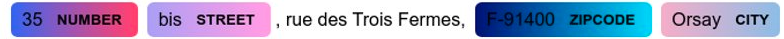
<div>
In het voorbeeld is duidelijk tezien dat het moelijk is om het onderscheit te bepalen tussen wat juist bij de straat hoort en wat juist bij het nummer hoort
</div>
Voor enkele landen hebben we niet genoeg data om mee te gaan werken voor het trainen van ons model en het valideren. We kunnen niet op een ocrrecte manier gaan zeggen of het een goed model 
</div>


#### Windows
<div class="alert alert-block alert-info">python TestModel.py</div>

#### Linux
<div class="alert alert-block alert-info">python3 TestModel.py</div>

<div class="alert alert-block alert-warning">We hebben de laatste 3 regels in commentaar geplaatst zodat de output van de Jupyter notebook niet te lang werd. We raden aan om het commando in terminal uit te voeren als u de volledige uitkomst wilt bekijken. U kan het resultaat bekijken door naar de link <a href="http://localhost:5000">http://localhost:5000</a> te gaan.</div>

### EU

In [11]:
import csv
from curses.ascii import ctrl
import spacy
import pandas as pd
from spacy.tokens import DocBin
from spacy import displacy

test_text = []
df = pd.read_pickle("./EU/data/samples/500ksample-europefilter-address.pkl")

labeledData = open('./EU/data/validation/validation_EU.txt', 'r')
adreslist = []
for line in labeledData.readlines():
    line = line.strip('\n')
    line = line.split("&")
    record = []
    recordtuple = (line[0],record)
    for i in line:
        i = i.split(";")
        record.append(i)
    record.pop(0)
    adreslist.append(recordtuple)

nlp = spacy.load("./EU/model/model-best")
# nlp = spacy.load("./EU/model/model-last")
lijst = []
correct_counter = 0
total_counter = 0
total_counter_straat = 0
total_counter_nummer = 0
total_counter_city = 0
total_counter_zipcode = 0
ctry_code = ""

def validate(row):
    global lijst
    global correct_counter
    global total_counter
    global total_counter_straat
    global total_counter_nummer
    global total_counter_city
    global total_counter_zipcode
    global ctry_code
    adres_ctry_code = row.person_ctry_code
    full_address = row.address_1 + ',' + row.address_2
    doc = nlp(full_address)
    ents = list(doc.ents)
    for at in adreslist:
        if at[0] == str(doc):
            for j in at[1]:
                for token in ents:
                    bool1 = str(j[0]) == str(token.start_char)
                    bool2 = str(j[1]) == str(token.end_char)
                    bool3 = j[2] == token.label_
                    if bool1 and bool2 and bool3 and token.label_ == "STREET":
                        total_counter_straat +=1
                    if bool1 and bool2 and bool3 and token.label_ == "NUMBER":
                        total_counter_nummer +=1
                    if bool1 and bool2 and bool3 and token.label_ == "CITY":
                        total_counter_city +=1
                    if bool1 and bool2 and bool3 and token.label_ == "ZIPCODE":
                        total_counter_zipcode +=1
    lijst.append(doc)
    total_counter += 1
    if ctry_code != adres_ctry_code:
        print("----------------------" + ctry_code + "--------------------------------")
        print("straat: " + str(total_counter_straat) + " percentage: " + str(total_counter_straat / total_counter * 100)+ "%")
        print("nummer: " + str(total_counter_nummer) + " percentage: " + str(total_counter_nummer / total_counter * 100)+ "%")
        print("city: " + str(total_counter_city) + " percentage: " + str(total_counter_city / total_counter * 100)+ "%")
        print("zipcode: " + str(total_counter_zipcode) + " percentage: " + str(total_counter_zipcode / total_counter * 100)+ "%")
        print("counter: " + str(total_counter))
        ctry_code = adres_ctry_code
        total_counter = 0
        total_counter_straat = 0
        total_counter_nummer = 0
        total_counter_city = 0
        total_counter_zipcode = 0

df.apply(lambda x: validate(x),axis=1)

# colors = {"STREET": "linear-gradient(90deg, #aa9cfc, #fc9ce7)", "NUMBER": "linear-gradient(90deg, #3f5efb, #fc466b)", "ZIPCODE": "linear-gradient(90deg, #090979, #00d4ff)", "CITY": "linear-gradient(90deg, #eeaeca, #94bbe9)", "OTHER": "linear-gradient(90deg, #22c1c3, #fdbb2d)",}
# options = {"ents": ["CITY", "STREET", "NUMBER", "ZIPCODE", "OTHER"], "colors": colors}
# displacy.serve(lijst, style="ent", options=options)



------------------------------------------------------
straat: 1 percentage: 100.0%
nummer: 1 percentage: 100.0%
city: 1 percentage: 100.0%
zipcode: 1 percentage: 100.0%
counter: 1
----------------------AT--------------------------------
straat: 334 percentage: 84.98727735368958%
nummer: 329 percentage: 83.7150127226463%
city: 360 percentage: 91.6030534351145%
zipcode: 369 percentage: 93.89312977099237%
counter: 393
----------------------BE--------------------------------
straat: 282 percentage: 61.97802197802198%
nummer: 278 percentage: 61.0989010989011%
city: 351 percentage: 77.14285714285715%
zipcode: 381 percentage: 83.73626373626374%
counter: 455
----------------------BG--------------------------------
straat: 1 percentage: 16.666666666666664%
nummer: 1 percentage: 16.666666666666664%
city: 3 percentage: 50.0%
zipcode: 4 percentage: 66.66666666666666%
counter: 6
----------------------CY--------------------------------
straat: 6 percentage: 75.0%
nummer: 5 percentage: 62.5%
city: 4

3093713     None
65461480    None
2823340     None
2752471     None
2902070     None
            ... 
94830116    None
53277909    None
68293677    None
52990671    None
91574838    None
Length: 14747, dtype: object

### USA

In [ ]:
import csv
import spacy
import pandas as pd
from spacy.tokens import DocBin
from spacy import displacy

# test_text = ["Keilalahdentie 4,02150 Espoo", "Weisshsusstrasse 2,52066 Aachen", "14 rue Royale,75008 Paris", "Hüninger Strasse 25,14195 Berlin", "19 bis rue Hoche,49100 Angers"]
test_text = []

df = pd.read_pickle("./USA/data/samples/500ksample-americanfilter-address.pkl")

labeledData = open('./USA/data/validation/validation_USA.txt', 'r')
adreslist = []
for line in labeledData.readlines():
    line = line.strip('\n')
    line = line.split("&")
    record = []
    recordtuple = (line[0],record)
    for i in line:
        i = i.split(";")
        record.append(i)
    record.pop(0)
    adreslist.append(recordtuple)

nlp = spacy.load("./USA/model/model-best")
# nlp = spacy.load("./USA/model/model-last")
lijst = []
correct_counter = 0
total_counter = 0
total_correct_straat = 0
total_correct_nummer = 0
total_correct_city = 0
total_correct_zipcode = 0
total_correct_state = 0

total_straat = 0
total_nummer = 0
total_city = 0
total_zipcode = 0
total_state = 0

def validate(row):
    global total_counter
    global total_correct_straat
    global total_correct_nummer
    global total_correct_city
    global total_correct_zipcode
    global total_correct_state

    global total_straat
    global total_nummer
    global total_city
    global total_zipcode
    global total_state 
    full_address = row.address_1 + ',' + row.address_2
    doc = nlp(full_address)
    ents = list(doc.ents)
    for at in adreslist:
        if at[0] == str(doc):
            for j in at[1]:
                for token in ents:
                    bool1 = str(j[0]) == str(token.start_char)
                    bool2 = str(j[1]) == str(token.end_char)
                    bool3 = j[2] == token.label_
                    if bool1 and bool2 and bool3 and token.label_ == "STREET":
                        total_correct_straat +=1
                    if bool1 and bool2 and bool3 and token.label_ == "NUMBER":
                        total_correct_nummer +=1
                    if bool1 and bool2 and bool3 and token.label_ == "CITY":
                        total_correct_city +=1
                    if bool1 and bool2 and bool3 and token.label_ == "ZIPCODE":
                        total_correct_zipcode +=1
                    if bool1 and bool2 and bool3 and token.label_ == "STATE":
                        total_correct_state +=1
                if j[2] == "STREET":
                    total_straat += 1
                if j[2] == "NUMBER":
                    total_nummer += 1
                if j[2] == "CITY":
                    total_city += 1
                if j[2] == "ZIPCODE":
                    total_zipcode += 1
                if j[2] == "STATE":
                    total_state += 1
    lijst.append(doc)
    total_counter += 1

df.apply(lambda x: validate(x),axis=1)

print("straat: " + str(total_correct_straat) + " percentage: " + str(total_correct_straat / total_straat * 100)+ "%")
print("nummer: " + str(total_correct_nummer) + " percentage: " + str(total_correct_nummer / total_nummer* 100)+ "%")
print("city: " + str(total_correct_city) + " percentage: " + str(total_correct_city / total_city* 100)+ "%")
print("zipzode: " + str(total_correct_zipcode) + " percentage: " + str(total_correct_zipcode / total_zipcode* 100)+ "%")
print("state: " + str(total_correct_state) + " percentage: " + str(total_correct_state / total_state* 100)+ "%")
print("adress in list: " + str(total_counter))

# colors = {"STREET": "linear-gradient(90deg, #aa9cfc, #fc9ce7)", "NUMBER": "linear-gradient(90deg, #3f5efb, #fc466b)", "ZIPCODE": "linear-gradient(90deg, #090979, #00d4ff)", "CITY": "linear-gradient(90deg, #eeaeca, #94bbe9)", "STATE": "linear-gradient(90deg, #22c1c3, #fdbb2d)",}
# options = {"ents": ["CITY", "STREET", "NUMBER", "ZIPCODE", "STATE"], "colors": colors}
# displacy.serve(lijst, style="ent", options=options)



### Bronnen
<div>Hier is de lijst met bronnen die we gebruikt hebben om dit project te verwezelijken:</div>
<div><a href="https://www.machinelearningplus.com/spacy-tutorial-nlp/">https://www.machinelearningplus.com/spacy-tutorial-nlp/</a></div>
<div><a href="https://machinelearningknowledge.ai/spacy-nlp-pipeline-tutorial-for-beginners/">https://machinelearningknowledge.ai/spacy-nlp-pipeline-tutorial-for-beginners/</a> </div>
<div><a href="https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/">https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/</a> </div>
<div><a href="https://spacy.io/usage">https://spacy.io/usage</a> </div>
<div><a href="https://spacy.io/api/tokenizer">https://spacy.io/api/tokenizer</a> </div>
<div><a href="https://machinelearningknowledge.ai/complete-guide-to-spacy-tokenizer-with-examples/#Adding_Special_Rule">https://machinelearningknowledge.ai/complete-guide-to-spacy-tokenizer-with-examples/#Adding_Special_Rule</a> </div>
<div><a href="https://docs.microsoft.com/en-us/azure/cognitive-services/language-service/custom-named-entity-recognition/how-to/improve-model">https://docs.microsoft.com/en-us/azure/cognitive-services/language-service/custom-named-entity-recognition/how-to/improve-model</a> </div>
<div><a href="https://thispointer.com/pandas-select-rows-without-nan-values/">https://thispointer.com/pandas-select-rows-without-nan-values/</a> </div>
<div><a href="https://www.creativeeurope.be/sites/creativeeurope/files/media/landencodes.pdf">https://www.creativeeurope.be/sites/creativeeurope/files/media/landencodes.pdf</a> </div>
<div><a href="https://regex101.com/">https://regex101.com/</a> </div>
<div><a href="https://www.geeksforgeeks.org/transliterating-non-ascii-characters-with-python/">https://www.geeksforgeeks.org/transliterating-non-ascii-characters-with-python/</a> </div>
<div><a href="https://spacy.io/usage/visualizers">https://spacy.io/usage/visualizers</a> </div>
<div><a href="https://www.askpython.com/python/examples/precision-and-recall-in-python">https://www.askpython.com/python/examples/precision-and-recall-in-python</a> </div>
<div><a href="https://cloudxlab.com/blog/numpy-pandas-introduction/">https://cloudxlab.com/blog/numpy-pandas-introduction/</a> </div>
<div><a href="https://realpython.com/pandas-dataframe/#accessing-and-modifying-data">https://realpython.com/pandas-dataframe/#accessing-and-modifying-data</a> </div>
<div><a href="https://www.tutorialspoint.com/spacy/index.htm">https://www.tutorialspoint.com/spacy/index.htm</a> </div>
<div><a href="https://realpython.com/natural-language-processing-spacy-python/">https://realpython.com/natural-language-processing-spacy-python/</a> </div>
<div><a href="https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/">https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/</a> </div>
<div><a href="https://machinelearningknowledge.ai/complete-guide-to-spacy-tokenizer-with-examples/">https://machinelearningknowledge.ai/complete-guide-to-spacy-tokenizer-with-examples/</a></div>